# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "sofiane"
ln1 = "ennadir"
fn2 = "mohammed-amine"
ln2 = "abboudi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_ennadir_sofiane_and_abboudi_mohammed-amine.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [4]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [13]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 5000
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


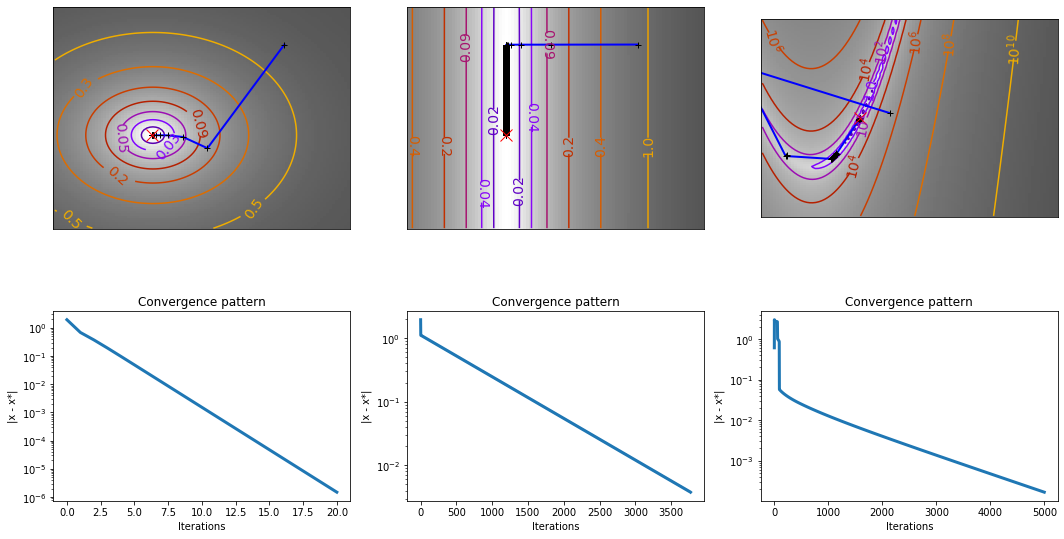

In [14]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [33]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    #c1 = 0.001
    c2 = 0.95
    max_iter = 200
    lambda_threshold = 0.01 

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        ######
        
        # Compute the Hessian
        H = f_hessian(x)
        
        # Regularization of the Hessian
        lmb = np.min(np.linalg.eigvals(H))
        if lmb < 0:
            H -= (lmb - lambda_threshold) * np.eye(len(x))
            
        # Computing the search direction d
        d, _ = cg(H,grad_x)
        d    = - np.array(d)
        
        ######
        
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


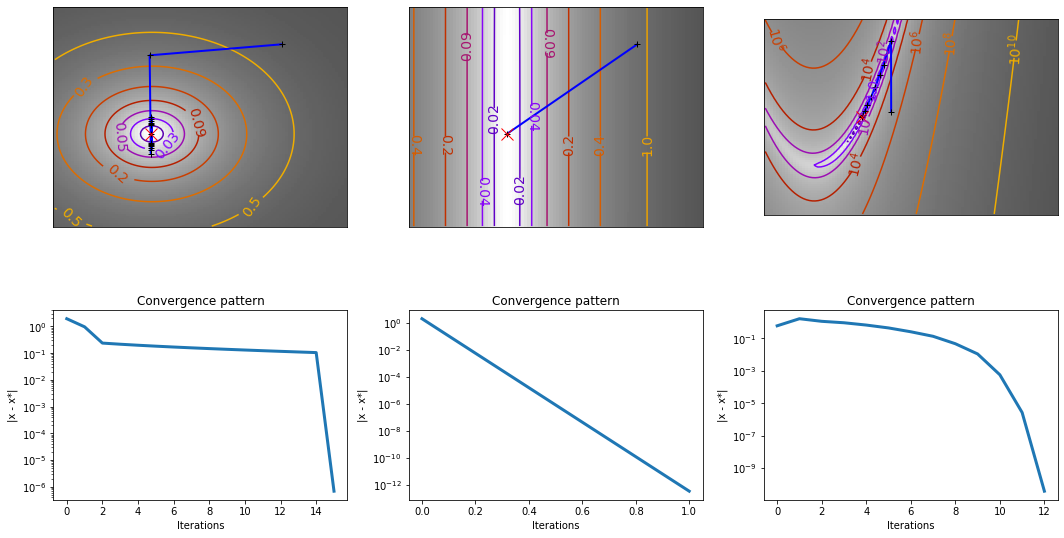

In [34]:
test_solver(newton)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Comments</span>
<ul>
For the first function which is a non-convex Guassian Kernel, the regularization of the Hessian is necessary in order to avoid having negative so as to convergence of the Line Search.

<br>
<ol> Now let us consider the second case which is a Quadratic Function:
    <li>
        We can notice that for the second function which is a Quadratic function, the convergence is straight forward and is reached after one iteration and is independent of the conditioning, like what we've seen during the theoritical course. In fact, we recall that the said iteration would be : <br>
        <center>$x^{1} = x^{0} - \nabla^2f(x^{0})^{-1}\nabla f(x^{0}) = A^{-1}b $</center> with $f(x) = \frac{1}{2}x^TAx - b^Tx+c$.
    </li>
    <li>The Newton Method convergences faster  than Gradient Descent in terms of the number of iterations. In fact,the Newton method converges only in one iteration, while for GD, it didn't converge after 200 iterations, it takes around 3000 iterations .  </li>
    </ol>
    
<br>
    
<ol> Let's now consider the third case which is the Rosenbrock Function :
    <li>
       The Rosenbrock function is known to be a hard optimization problem because of that flat part that it contains, getting to the flat part only takes a few iterations, but reaching the minimum takes much longer. 
    </li>
    <li> In terms of convergence, the Newton Method is much more effecient and is much faster than *GD*, because the reached convergence point is much more precise and was reached in 12 Iterations. 
    </li>

</ol>
  
<br>
<ol> Let's finally consider the first case which was the Gaussian Kernel :
    
<li>
    For the Non-Convex Gaussian Kernel, one can see that the first iterations were pretty good and after some oscillations, the algorithm reached an interesting point and this could be explained because of the fact that our function is known to be dominated by its quadratic approximation and as result some overshooting and oscillating can be expected.
</li>
    <li> Using the parameter $C_1$, which refers to the Armijo rule and ensures that the step length $\alpha_{k}$ decreases $f$. Basically, when changing this parameter, we can help attenuate the oscillation part during the convergence, which help to converge faster, this could be seen when changing $C_1$ from $10^{-4}$ to $10^{-2}$.
    </li>
    <li> In term of convergence, the Newton method is also much more effecient and much faster than the GD in this case. 
    </li>    

</ol>
    
</ul>
</div>

# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [16]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    
    x = x0
    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        B = B + np.outer(s,s)/np.dot(s,y) - np.dot(B,np.outer(y,np.dot(y.T,B))) / np.dot(y.T,np.dot(B,y))
        
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


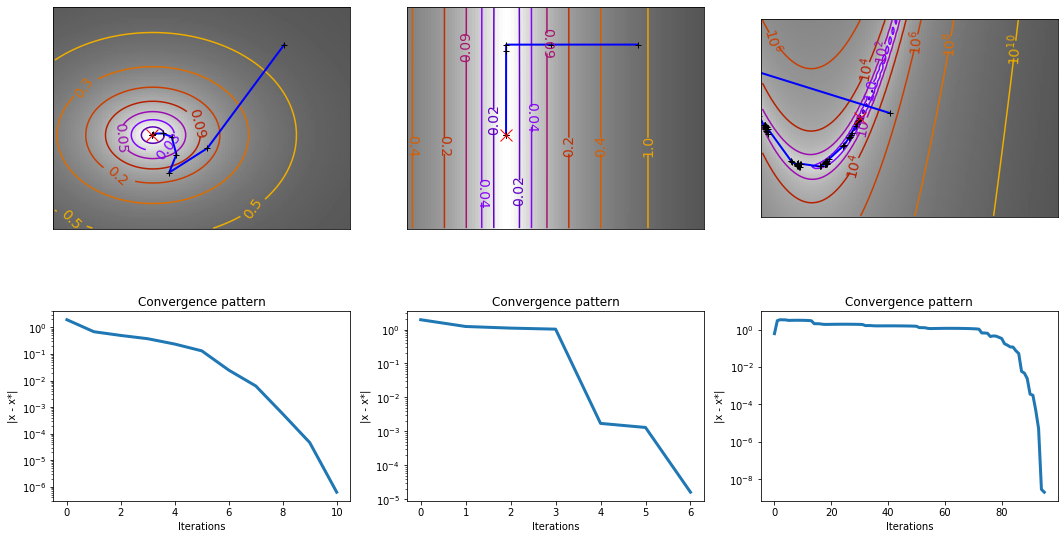

In [17]:
test_solver(dfp)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Comments</span>
<ul>
In this second part, the goal is to implement the Davidon-Fletcher-Powell algorithm. We recall that this method is a second order method that consists of the following correction of the inverse hessian approximation, $B$ : 
    <center> $B_{k+1} = B_{k} + \frac{s_ks_k^T}{s_k^Ty_k} - \frac{B_ky_ky_k^TB_k}{y_k^TB_ky_k}$ </center>

<br>
<ol> Let's consider the second case which is the Quadratic Function:
    
<li>
        We recall that in our theoritical approach, we have proven that in the case of a quadratic function, our algorithm should converges in $n$ iterations at most. In our case, $n = 2$ , but the convergence was done after 6 iterations. This could be explained by our use of Inexact Line Search Method, in fact, our Line Search is not exact and using this method, we only have a good step size but not the optimal one. 
    </li>
    
<li>In term of convergence, the DFP Method is still much faster than the GD but is much slower comparing to the Newton Method previously implemented.  
    </li>
    
</ol>
 
<li> While the number of iterations to reach convergence for the Rosenbrock function increased, passing from roughly 12 to 100, the number of iterations for the non-convex Gaussian Kernel has decreased. This may be due to the approximation of $A$ being less accurate for the case of the Rosenbrock function and by consequence the search direction that is computed in not very accurate. 
</li>

    
</ul>
</div>

# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [18]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(linalg.inv(B), grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        B = B + np.outer(y,y)/np.dot(s,y) - np.dot(B,np.outer(s,np.dot(s.T,B))) / np.dot(s.T,np.dot(B,s))
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


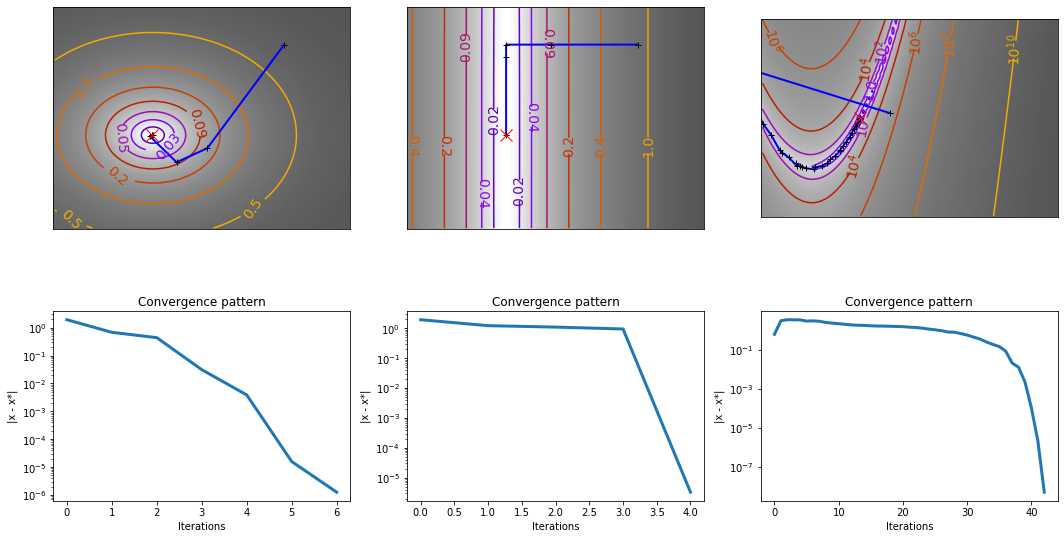

In [19]:
test_solver(bfgs)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Comments</span>
<ul>
In this third part, we are going to use an implementation of the BFGS Algorithm using the following update formula : 

    
<center> $H_{k+1} = H_{k} + \frac{y_ky_k^T}{y_k^Ts_k} - \frac{H_ks_ks_k^TB_k}{s_k^TB_ks_k}$ </center>
    
 
<li> 
    For the quadratic function, BFGS is known for not being as fast as Newton's method, and this is clear in the results that we have gotten ( 1 iteration for the Newton Method and 4 for BFGS).
</li>
    
<li>
    For the Non-Convex Gaussian Kernel, the BFGS is much faster than the Newton method and that could be explained by the fact that its empirical estimate of the curvature is better than that given by the Hessian.
    </li>
    
<li>
    The total number of iterations to get to convergence has decreased and that may related to the fact that BFGS Algorithm is less sentisitive than the DFP Algorithm to step size.
    </li>
    
<li> In our implementation and at each iteration we are solving the system $d_k = -H_k^{-1}\nabla f(x_k) $ in order to have the step size. The cost of this operation is $\mathcal{O}(n^3)$, while in DFP it was $\mathcal{O}(n^2)$, so the number of iterations to reach converge in this implementation should be higher than the number of iterations in DFP. In our case, we can't compare them because our implementation of DFP is not using Exact Line Search, and only uses a non-optimal approach. To be noted that in term of speed of convergence, our implementation of BFGS is faster than our implementation of DFP.
    </li>
   

    
</ul>
</div>

# Part 3: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [20]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = np.zeros(m)
    # TODO : first loop
    if len(y_list) == m:
        for i in range(m-1,-1,-1):
            try:
                alpha_list[i] = (np.dot(s_list[i],q)/np.dot(y_list[i],s_list[i]))
            except:
                alpha_list[i] = 0
            q -= alpha_list[i]*y_list[i]
        
    r = np.dot(B0, q)
    # TODO: second loop
    if len(y_list) == m:
        for i in range(m):
            try:
                beta = np.dot(y_list[i],r)/np.dot(y_list[i],s_list[i])
            except:
                beta = 0
            r += s_list[i] * (alpha_list[i]-beta)
    return -r

In [21]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 5
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step


        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


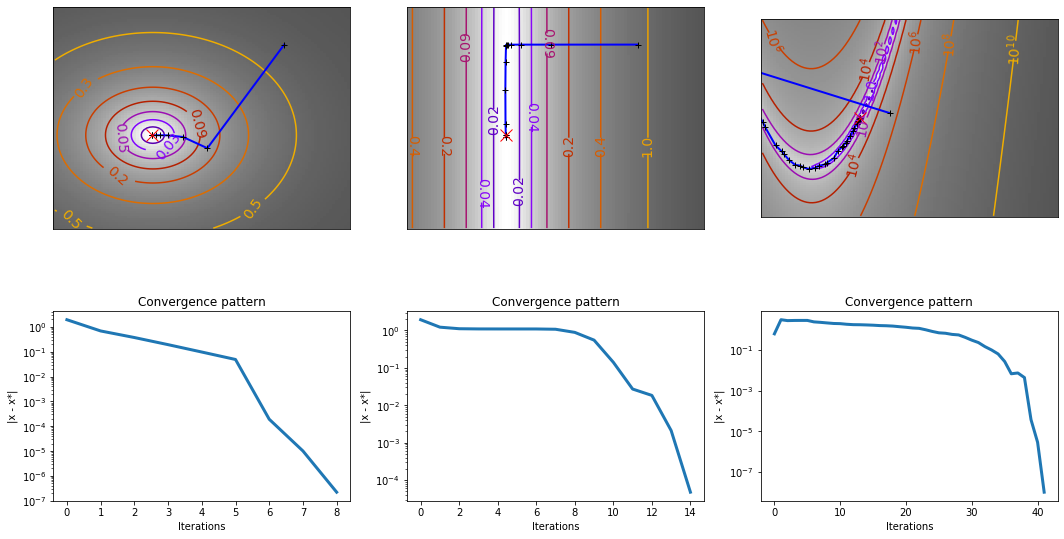

In [22]:
test_solver(lbfgs)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Comments</span>
<ul>
In this final part, we are implementing the Limited-memory BFGS Algorithm L-BFGS, which resolves the complexity of computing and inverting the Hessian. 
   
 
<li> In term of Speed of convergence, our implementation of L-BFGS wasn't faster than the BFGS and this may be due to the fact that we are working with $n = 2$ so the difference wouldn't be so clear. 

</li>
    
   

    
</ul>
</div>

<div class="alert alert-warning">
<span class="label label-primary" style="font-size:15px;">Summary</span>
<ul>
   
 
<li> The Newton Method seems to be the most effective in optimizing the functions that we are using. The L-BFGS, BFGS and DFP are still much faster than the GD but slower than the Newton Implemenatation. 
</li>
    
<li> Basically, if one can compute the Hessian, it's preferable to opt for the Newton Method as it is the most effecient and the fastest, which was the case in this session. BFGS and L-BFGS are practical when we have to approximate the gradients. 
    </li>

    
</ul>
</div>